In [16]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ModuleDict
from torch_geometric.data import DataLoader
from torch_geometric.nn import HeteroConv, global_mean_pool
from torch_geometric.data import HeteroData
from torch_geometric.transforms import ToUndirected
import os
import glob

GRAPH_FOLDER = "heterographs/"
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")


In [17]:
import json

with open("data/labels.json") as f:
    labels_dict = json.load(f)

graphs, labels = [], []

for file in glob.glob(os.path.join(GRAPH_FOLDER, "*.pt")):
    graph = torch.load(file, weights_only=False)
    graph = ToUndirected()(graph)
    graph['label'] = torch.tensor([labels_dict[os.path.basename(file)]], dtype=torch.float)
    graphs.append(graph)
    labels.append(labels_dict[os.path.basename(file)])


In [18]:
# 3. Split into train/test
from sklearn.model_selection import train_test_split

train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, stratify=labels, random_state=42)
train_loader = DataLoader(train_graphs, batch_size=2, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=2)
print(f"Number of training graphs: {len(train_graphs)}")
print(f"Number of test graphs: {len(test_graphs)}")

Number of training graphs: 34
Number of test graphs: 9


/home/raasikhk/anaconda3/envs/cs485/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [19]:
from torch.nn import ReLU, Dropout
from torch_geometric.nn import SAGEConv

class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata):
        super().__init__()
        self.conv1 = HeteroConv({
            edge_type: SAGEConv((-1, -1), 32)
            for edge_type in metadata[1]
        }, aggr='sum')

        self.lin = Linear(32, 1)

    def forward(self, x_dict, edge_index_dict, batch_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        pooled = []
        for node_type in x_dict:
            pooled.append(global_mean_pool(x_dict[node_type], batch_dict[node_type]))
        out = torch.stack(pooled).sum(dim=0)  # sum all node embeddings
        return self.lin(out).view(-1)

In [20]:
# Instantiate model
metadata = train_graphs[0].metadata()
model = HeteroGNN(metadata).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCEWithLogitsLoss()

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Train/test + loss functions
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x_dict, data.edge_index_dict, data.batch_dict)
        loss = criterion(out, data['label'].to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = torch.sigmoid(model(data.x_dict, data.edge_index_dict, data.batch_dict))
            pred = (out > 0.5).float()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data['label'].cpu().numpy())
    
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return accuracy, precision, recall, f1


In [22]:
import pandas as pd
import numpy as np

df = pd.DataFrame(columns=['epoch', 'loss', 'accuracy', 'precision', 'recall', 'f1'])
f1_logs = []
best_f1 = 0

# training loop
for epoch in range(1, 301):
    loss = train()
    accuracy, precision, recall, f1 = test(test_loader)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Test Acc: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        f1_logs.append({
            "epoch": epoch,
            "loss": loss,
            "f1": f1,
            "model_state": model.state_dict()
        })


    # Append logs to the dataframe
    new_row = {'epoch': epoch, 'loss': f"{loss}", 'accuracy': f"{accuracy}", 
               'precision': f"{precision}", 'recall': f"{recall}", 'f1': f"{f1}"}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    if loss < 0.01:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Test Acc: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        break

# Save the dataframe as csv
df.to_csv("model/hetero_gnn_training_results.csv", index=False)

# Choose the best model
max_f1_epochs = [log for log in f1_logs if log["f1"] == best_f1]
if len(max_f1_epochs) > 1:
    best_epoch_log = min(max_f1_epochs, key=lambda x: x["loss"])
else:
    best_epoch_log = max_f1_epochs[0]

best_epoch = best_epoch_log["epoch"]
best_model_state = best_epoch_log["model_state"]

# Save the model
torch.save(best_model_state, f"model/hetero_gnn_epoch_{best_epoch}.pth")

/home/raasikhk/anaconda3/envs/cs485/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raasikhk/anaconda3/envs/cs485/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10, Loss: 312.9466, Test Acc: 0.6667, Precision: 0.6667, Recall: 0.8000, F1: 0.7273


/home/raasikhk/anaconda3/envs/cs485/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20, Loss: 387.8004, Test Acc: 0.5556, Precision: 0.6000, Recall: 0.6000, F1: 0.6000


/home/raasikhk/anaconda3/envs/cs485/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30, Loss: 230.7381, Test Acc: 0.5556, Precision: 0.6000, Recall: 0.6000, F1: 0.6000


/home/raasikhk/anaconda3/envs/cs485/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raasikhk/anaconda3/envs/cs485/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40, Loss: 200.0978, Test Acc: 0.6667, Precision: 0.7500, Recall: 0.6000, F1: 0.6667


/home/raasikhk/anaconda3/envs/cs485/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50, Loss: 121.3628, Test Acc: 0.6667, Precision: 0.6667, Recall: 0.8000, F1: 0.7273


/home/raasikhk/anaconda3/envs/cs485/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 60, Loss: 362.9083, Test Acc: 0.6667, Precision: 1.0000, Recall: 0.4000, F1: 0.5714


/home/raasikhk/anaconda3/envs/cs485/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raasikhk/anaconda3/envs/cs485/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 70, Loss: 225.8088, Test Acc: 0.4444, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 80, Loss: 174.6737, Test Acc: 0.6667, Precision: 0.6667, Recall: 0.8000, F1: 0.7273
Epoch 90, Loss: 58.4432, Test Acc: 0.6667, Precision: 0.7500, Recall: 0.6000, F1: 0.6667


/home/raasikhk/anaconda3/envs/cs485/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 100, Loss: 83.5886, Test Acc: 0.5556, Precision: 0.6000, Recall: 0.6000, F1: 0.6000
Epoch 110, Loss: 107.0431, Test Acc: 0.5556, Precision: 0.6000, Recall: 0.6000, F1: 0.6000
Epoch 120, Loss: 127.3034, Test Acc: 0.5556, Precision: 1.0000, Recall: 0.2000, F1: 0.3333
Epoch 130, Loss: 107.3484, Test Acc: 0.5556, Precision: 0.6000, Recall: 0.6000, F1: 0.6000
Epoch 140, Loss: 64.5242, Test Acc: 0.5556, Precision: 0.6667, Recall: 0.4000, F1: 0.5000


/home/raasikhk/anaconda3/envs/cs485/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 150, Loss: 45.5653, Test Acc: 0.6667, Precision: 0.7500, Recall: 0.6000, F1: 0.6667
Epoch 160, Loss: 20.6006, Test Acc: 0.6667, Precision: 0.7500, Recall: 0.6000, F1: 0.6667
Epoch 170, Loss: 110.4089, Test Acc: 0.5556, Precision: 0.6000, Recall: 0.6000, F1: 0.6000
Epoch 180, Loss: 41.3002, Test Acc: 0.5556, Precision: 0.6000, Recall: 0.6000, F1: 0.6000
Epoch 190, Loss: 25.1153, Test Acc: 0.6667, Precision: 0.7500, Recall: 0.6000, F1: 0.6667
Epoch 200, Loss: 7.0721, Test Acc: 0.5556, Precision: 0.6000, Recall: 0.6000, F1: 0.6000
Epoch 210, Loss: 27.9486, Test Acc: 0.5556, Precision: 0.6000, Recall: 0.6000, F1: 0.6000
Epoch 220, Loss: 20.2171, Test Acc: 0.6667, Precision: 1.0000, Recall: 0.4000, F1: 0.5714


/home/raasikhk/anaconda3/envs/cs485/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 230, Loss: 70.9217, Test Acc: 0.6667, Precision: 0.7500, Recall: 0.6000, F1: 0.6667
Epoch 240, Loss: 37.2648, Test Acc: 0.5556, Precision: 0.6000, Recall: 0.6000, F1: 0.6000
Epoch 250, Loss: 30.4255, Test Acc: 0.7778, Precision: 1.0000, Recall: 0.6000, F1: 0.7500
Epoch 260, Loss: 6.9351, Test Acc: 0.7778, Precision: 1.0000, Recall: 0.6000, F1: 0.7500
Epoch 270, Loss: 9.3623, Test Acc: 0.7778, Precision: 1.0000, Recall: 0.6000, F1: 0.7500
Epoch 280, Loss: 17.2910, Test Acc: 0.7778, Precision: 1.0000, Recall: 0.6000, F1: 0.7500
Epoch 290, Loss: 17.6131, Test Acc: 0.7778, Precision: 1.0000, Recall: 0.6000, F1: 0.7500
Epoch 300, Loss: 9.1333, Test Acc: 0.5556, Precision: 0.6000, Recall: 0.6000, F1: 0.6000


Epoch with maximum F1-score: 15, Loss at this epoch: 600.435884363511, F1 Score: 0.8333333333333333
Epoch with minimum Loss: 224, Loss at this epoch: 1.8849818595990653, F1 Score: 0.6666666666666665
Chosen model:
Best Epoch: 15, F1 Score: 0.8333333333333333, Loss: 600.435884363511


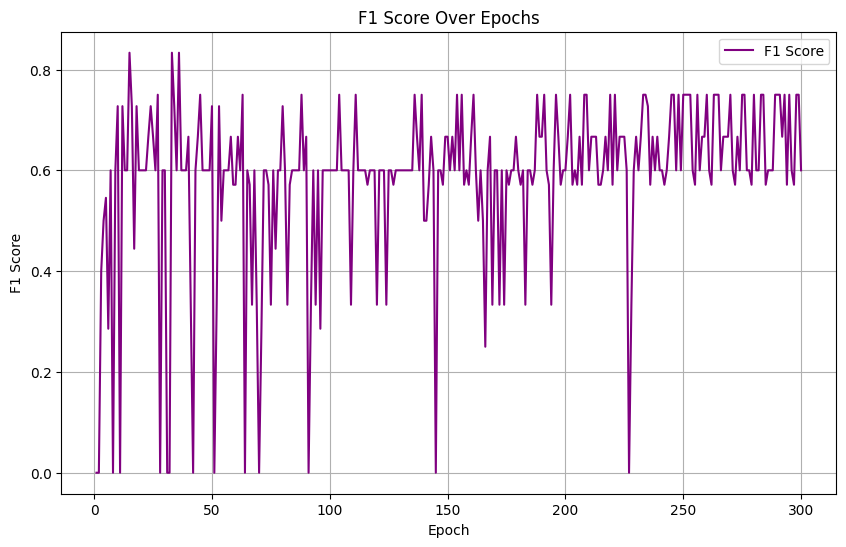

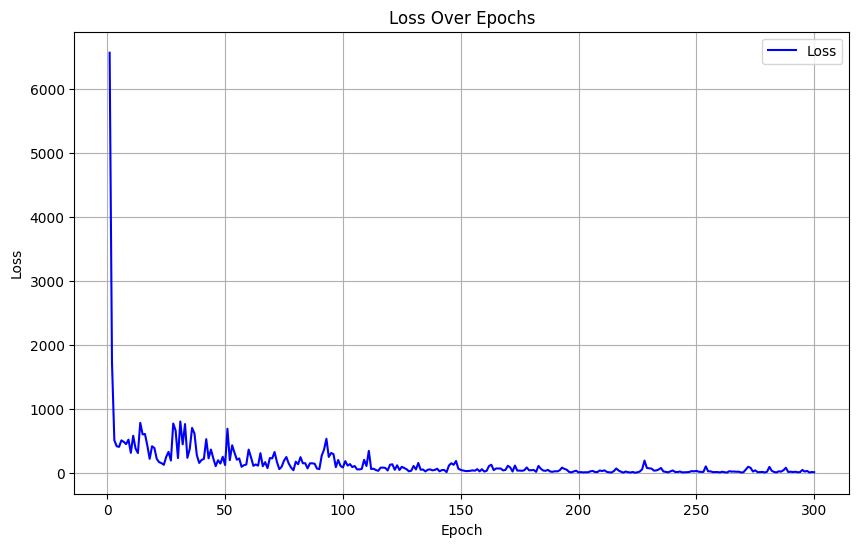

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("model/hetero_gnn_training_results.csv")
max_f1_epoch = df.loc[df['f1'].idxmax(), 'epoch']
max_f1_loss = df.loc[df['f1'].idxmax(), 'loss']
max_f1_score = df.loc[df['f1'].idxmax(), 'f1']
print(f"Epoch with maximum F1-score: {max_f1_epoch}, Loss at this epoch: {max_f1_loss}, F1 Score: {max_f1_score}")

min_loss_epoch = df.loc[df['loss'].idxmin(), 'epoch']
min_loss = df.loc[df['loss'].idxmin(), 'loss']
min_loss_f1_score = df.loc[df['loss'].idxmin(), 'f1']
print(f"Epoch with minimum Loss: {min_loss_epoch}, Loss at this epoch: {min_loss}, F1 Score: {min_loss_f1_score}")

print("Chosen model:")
print(f"Best Epoch: {best_epoch}, F1 Score: {best_f1}, Loss: {best_epoch_log['loss']}")

# Plot F1 vs Epoch
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['f1'], label='F1 Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss vs Epoch
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['loss'], label='Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()